In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

In [2]:
def use_device(use_cpu = 1):
    """
    Choose available CPU or GPU devices to use.
    """
    if (use_cpu == 1):
        device = '/device:CPU:0'
    else:
        device = '/device:GPU:0'
    return device

def xavier_init(channel_in, channel_out, constant = 1):
    """
    Xavier initialization of network weights
    """

    low = -constant * np.sqrt(6.0 / (channel_in + channel_out))
    high = constant * np.sqrt(6.0 / (channel_in + channel_out))
    return tf.random_uniform((channel_in, channel_out), minval = low, maxval = high, dtype=tf.float32)

class VAE(object):

    def __init__(self, network_architecture, learning_rate=0.001, batch_size=100, use_device='/device:CPU:0'):
        """
        Set up the VAE model.
        """

        # Set model parameters
        self.network_architecture = network_architecture
        self.lr = learning_rate
        self.batch_size = batch_size
        self.device = use_device

        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])

        # Forward pass
        self.forward()

        # Backward pass
        self.backward()

        # Initialize the variables and launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    def initialize_weights(self, n_hidden_enc_1, n_hidden_enc_2,
                           n_hidden_dec_1, n_hidden_dec_2, n_input, n_z):
        """
        Initialize weights of the network layers.
        """

        network_weights = dict()
        network_weights['encoder_weights'] = {
            'W1': tf.Variable(xavier_init(n_input, n_hidden_enc_1)),
            'W2': tf.Variable(xavier_init(n_hidden_enc_1, n_hidden_enc_2)),
            'W_mu': tf.Variable(xavier_init(n_hidden_enc_2, n_z)),
            'W_logvar': tf.Variable(xavier_init(n_hidden_enc_2, n_z))}
        network_weights['encoder_bias'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_enc_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_enc_2], dtype=tf.float32)),
            'b_mu': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
            'b_logvar': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}
        network_weights['decoder_weights'] = {
            'W1': tf.Variable(xavier_init(n_z, n_hidden_dec_1)),
            'W2': tf.Variable(xavier_init(n_hidden_dec_1, n_hidden_dec_2)),
            'W_out': tf.Variable(xavier_init(n_hidden_dec_2, n_input))}
        network_weights['decoder_bias'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_dec_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_dec_2], dtype=tf.float32)),
            'b_out': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        return network_weights


    def encode(self, weights, bias):
        """
        Use the encoder model to map the input data to the latent space.
        """
        with tf.device(self.device):
            hidden_1 = tf.nn.relu(tf.add(tf.matmul(self.x, weights['W1']), bias['b1']))
        with tf.device(self.device):    
            hidden_2 = tf.nn.relu(tf.add(tf.matmul(hidden_1, weights['W2']), bias['b2']))

        mu = tf.add(tf.matmul(hidden_2, weights['W_mu']), bias['b_mu'])
        logvar = tf.add(tf.matmul(hidden_2, weights['W_logvar']), bias['b_logvar'])
        return (mu, logvar)

    def decode(self, weights, bias):
        """
        Use the decoder model to reconstruct the input data.
        """
        with tf.device(self.device):
            hidden_1 = tf.nn.leaky_relu(tf.add(tf.matmul(self.z, weights['W1']), bias['b1']))
        with tf.device(self.device):
            hidden_2 = tf.nn.leaky_relu(tf.add(tf.matmul(hidden_1, weights['W2']), bias['b2']))

        recon_x = tf.nn.sigmoid(tf.add(tf.matmul(hidden_2, weights['W_out']), bias['b_out']))
        return recon_x


    def forward(self):
        """
        Build the VAE network.
        """

        # Initialize weights and bias
        network_weights = self.initialize_weights(**self.network_architecture)

        # Use encoder model to obtain latent z
        self.mu, self.logvar = self.encode(network_weights["encoder_weights"],
                                      network_weights["encoder_bias"])

        # Draw sample z from Gaussian using reparametrization trick
        n_z = self.network_architecture["n_z"]
        eps = tf.random_normal((self.batch_size, n_z), 0, 1, dtype=tf.float32)
        self.z = tf.add(self.mu, tf.multiply(tf.sqrt(tf.exp(self.logvar)), eps))

        # Use decoder model to obtain the reconstructed input
        self.recon_x = self.decode(network_weights["decoder_weights"],
                                    network_weights["decoder_bias"])


    def backward(self):
        """
        Calculate gradients using backpropagation and update weights using Adam optimizer.
        """

        rec_loss = - tf.reduce_sum(self.x * tf.log(1e-8 + self.recon_x)
                           + (1 - self.x) * tf.log(1e-8 + 1 - self.recon_x), 1)

        kl = -0.5 * tf.reduce_sum(1 + self.logvar - tf.square(self.mu) - tf.exp(self.logvar), 1)

        self.loss = tf.reduce_mean(rec_loss + kl)

        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.lr).minimize(self.loss)

    def train(self, X):
        """
        Train model based on mini-batch of input data.
        Return loss of mini-batch.
        """

        opt, loss = self.sess.run((self.optimizer, self.loss),
                                                feed_dict={self.x: X})
        return loss

    def transform(self, X):
        """
        Transform data by mapping it into the latent space.
        """
        # Note: This maps to mean of distribution, we could alternatively sample from Gaussian distribution
        return self.sess.run((self.mu, self.logvar), feed_dict={self.x: X})

    def generate(self, mu = None):
        """
        Generate data by sampling from the latent space.
        """
        if mu is None:
            # Data is alternatively generated from the prior in the latent space
            mu = np.random.normal(size = self.network_architecture["n_z"])

        return self.sess.run(self.recon_x, feed_dict={self.z: mu})

    def reconstruct(self, X):
        """
        Reconstruct the given input data.
        """

        return self.sess.run(self.recon_x, feed_dict={self.x: X})

In [3]:
def train(network_architecture, train_images, 
                learning_rate=0.001, batch_size=100, n_epoch=10, use_cpu=1):
    """
    Train the VAE model on the MNIST data set.
    """

    # Instantiate the model
    vae = VAE(network_architecture, learning_rate=learning_rate, batch_size=batch_size, use_device=use_device(use_cpu))

    # Load mnist data
    train_size = len(train_images)
    train_data = train_images

    # Record keeping
    train_elbo_lst = []
    #test_elbo_lst = []

    for epoch in range(n_epoch):

        train_loss = 0.
        #test_loss = 0.
        n_train_batch = train_size // batch_size
        #n_test_batch = test_size // batch_size

        # Train in mini-batches
        for idx in range(n_train_batch):
            train_batch = train_data[idx * batch_size:idx * batch_size + batch_size]
            loss = vae.train(train_batch)
            train_loss += loss
            
        train_elbo_lst.append(train_loss / n_train_batch)
        #test_elbo_lst.append(test_loss / n_test_batch)

        print("Epoch:", "%d/%d" % (epoch+1, n_epoch),
              "Train Loss =", "{:.4f}".format(train_loss / n_train_batch)
             )

    return vae, train_elbo_lst#, test_elbo_lst

In [4]:
from tensorflow.keras.datasets.cifar10 import load_data
(X_train, y_train), (X_test, y_test) = load_data()

In [5]:
train_data = X_train.reshape(-1, 32*32, 3) / 255
train_data = np.mean(train_data, axis=2)
print(train_data.shape)

(50000, 1024)


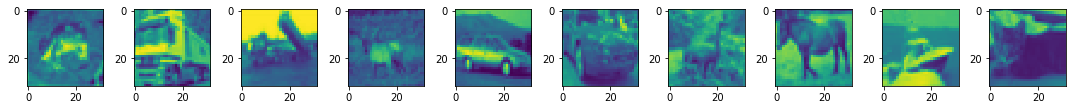

In [6]:
plt.figure(figsize=(15, 20))
for i in range(10):
    
    plt.subplot(2, 10, i+1)
    plt.imshow(train_data[i].reshape(32,32), vmin=0, vmax=1)

plt.tight_layout()

In [7]:
network_architecture = dict(n_hidden_enc_1 = 200,
                                 n_hidden_enc_2 = 200,
                                 n_hidden_dec_1 = 200,
                                 n_hidden_dec_2 = 200,
                                 n_input = 1024,
                                 n_z = 20)

vae, train_elbo = train(network_architecture, train_data, 
        learning_rate=0.001, n_epoch = 50, use_cpu = 1)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Epoch: 1/50 Train Loss = 661.4347
Epoch: 2/50 Train Loss = 643.2678
Epoch: 3/50 Train Loss = 639.5206
Epoch: 4/50 Train Loss = 638.1240
Epoch: 5/50 Train Loss = 636.9920
Epoch: 6/50 Train Loss = 636.3330
Epoch: 7/50 Train Loss = 635.9160
Epoch: 8/50 Train Loss = 635.7831
Epoch: 9/50 Train Loss = 635.4208
Epoch: 10/50 Train Loss = 635.2552
Epoch: 11/50 Train Loss = 635.0283
Epoch: 12/50 Train Loss = 634.8408
Epoch: 13/50 Train Loss = 634.5077
Epoch: 14/50 Train Loss = 634.2781
Epoch: 15/50 Train Loss = 634.1789
Epoch: 16/50 Train Loss = 634.0822
Epoch: 17/50 Train Loss = 633.9949
Epoch: 18/50 Train Loss = 633.8749
Epoch: 19/50 Train Loss = 633.8367
Epoch: 20/50 Train Loss = 633.7400
Epoch: 21/50 Train Loss = 633.6652
Epoch: 22/50 Train Loss = 633.4941
Epoch: 23/50 Train Loss = 633.4860
Epoch: 24/50 Train Loss = 633.3533
Epoch: 25/50 Train Loss = 633.2677
Epoch: 26/50 Train Loss = 633.2550
Epoch: 27/50 Train

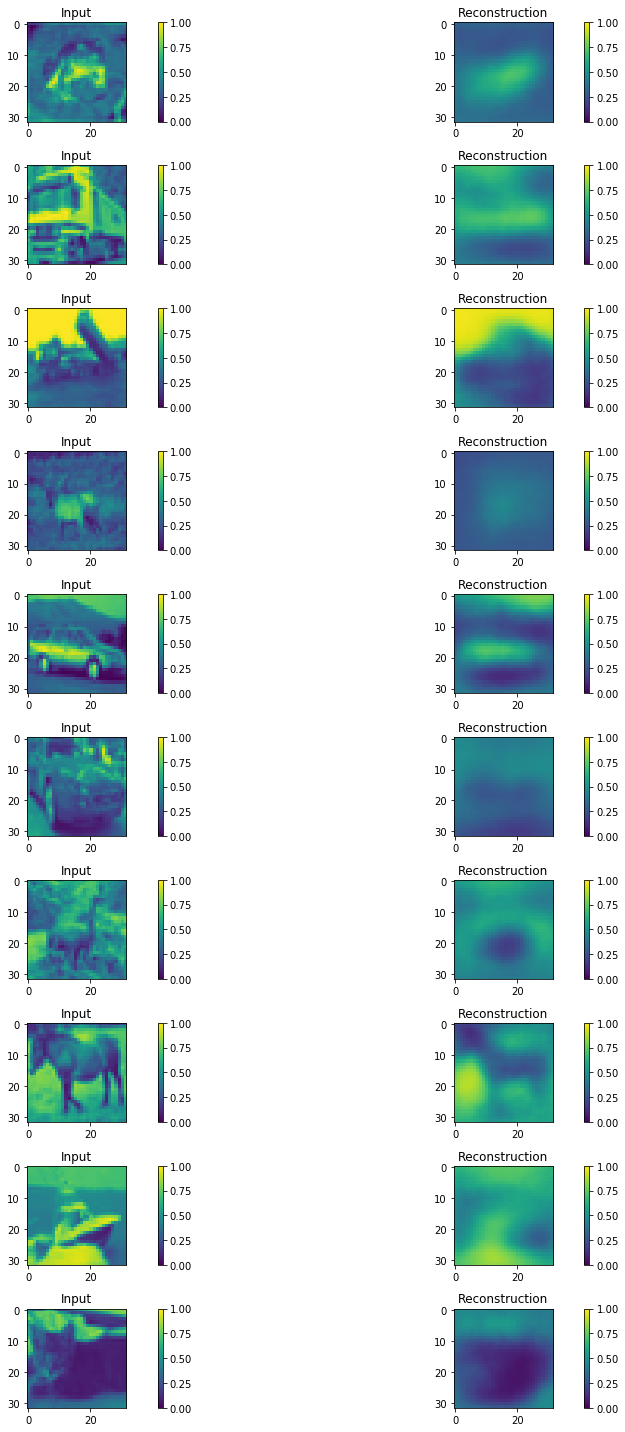

In [8]:
x_sample = train_data[:100,]
recon_x = vae.reconstruct(x_sample)

plt.figure(figsize=(15, 20))
for i in range(10):

    plt.subplot(10, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(32, 32), vmin=0, vmax=1)
    plt.title("Input")
    plt.colorbar()
    plt.subplot(10, 2, 2*i + 2)
    plt.imshow(recon_x[i].reshape(32, 32), vmin=0, vmax=1)
    plt.title("Reconstruction")
    plt.colorbar()
    
plt.tight_layout()

### Frey Face

In [9]:
from scipy.io import loadmat
from sklearn.preprocessing import normalize

In [10]:
frey_face = loadmat('../vae/data/frey_rawface.mat')
frey_face = frey_face['ff']
frey_face = np.swapaxes(frey_face, 1, 0) / 255
print(frey_face.shape)

(1965, 560)


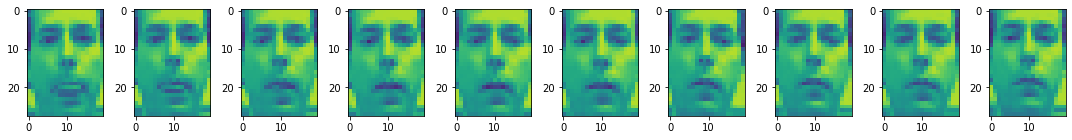

In [11]:
plt.figure(figsize=(15, 20))
for i in range(10):
    
    plt.subplot(2, 10, i+1)
    plt.imshow(frey_face[i].reshape(28, 20), vmin=0, vmax=1)

plt.tight_layout()

In [12]:
network_architecture = dict(n_hidden_enc_1 = 200,
                                 n_hidden_enc_2 = 200,
                                 n_hidden_dec_1 = 200,
                                 n_hidden_dec_2 = 200,
                                 n_input = 560,
                                 n_z = 20)

vae, train_elbo = train(network_architecture, frey_face, 
        learning_rate=0.001, n_epoch = 50, use_cpu = 1)

/Users/yizizhang/anaconda3/lib/python3.6/site-packages/tensorflow_core/python/client/session.py:1752: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch: 1/50 Train Loss = 374.3521
Epoch: 2/50 Train Loss = 355.9060
Epoch: 3/50 Train Loss = 354.0798
Epoch: 4/50 Train Loss = 353.7276
Epoch: 5/50 Train Loss = 353.5360
Epoch: 6/50 Train Loss = 353.4654
Epoch: 7/50 Train Loss = 353.3754
Epoch: 8/50 Train Loss = 353.3269
Epoch: 9/50 Train Loss = 353.2680
Epoch: 10/50 Train Loss = 353.3036
Epoch: 11/50 Train Loss = 353.1747
Epoch: 12/50 Train Loss = 353.1072
Epoch: 13/50 Train Loss = 353.1246
Epoch: 14/50 Train Loss = 353.0019
Epoch: 15/50 Train Loss = 353.0226
Epoch: 16/50 Train Loss = 352.9479
Epoch: 17/50 Train Loss = 352.9876
Epoch: 18/50 Train Loss = 352.9254
Epoch: 19/50 Train Loss = 352.8978
Epoch: 20/50 Train Loss = 352.8949
Epoch: 21/50 Train Loss = 352.9659
Epoch: 22/50 Train Loss = 352.8808
Epoch: 23/50 Train Loss = 352.8364
Epoch: 24/50 Train Loss = 352.7657
Epoch: 25/50 Train Loss = 352.7543
Epoch: 26/50 Train Loss = 352.7567
Epoch: 27/50 Train Loss = 352.7253
Epoch: 28/50 Train Loss = 352.7382
Epoch: 29/50 Train Loss = 352

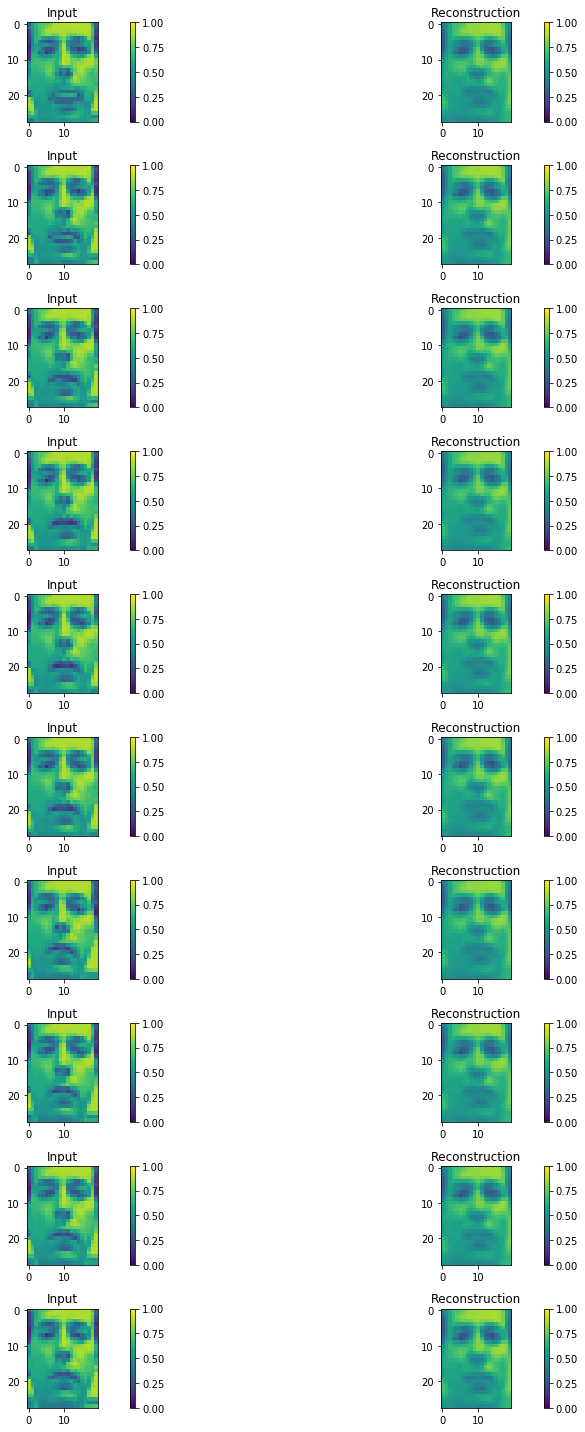

In [13]:
x_sample = frey_face[:100,]
recon_x = vae.reconstruct(x_sample)

plt.figure(figsize=(15, 20))
for i in range(10):

    plt.subplot(10, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 20), vmin=0, vmax=1)
    plt.title("Input")
    plt.colorbar()
    plt.subplot(10, 2, 2*i + 2)
    plt.imshow(recon_x[i].reshape(28, 20), vmin=0, vmax=1)
    plt.title("Reconstruction")
    plt.colorbar()
    
plt.tight_layout()